# IMPORTS

In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from config.metadata import PATHS
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from config.metadata import PATHS
import os
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow.keras.layers import (
    Dense,
    LSTM,
   
)
from tensorflow.keras.models import Sequential





In [86]:
def custom_loss(y_true, y_pred):
    # Definir los pesos para cada hora del día
    weights = np.ones(24) 
    weights[0] = 2
    weights[6:9] = 3
    weights[9] = 2  # Peso mayor para las horas de 6 a 8 de la mañana
    weights[18:20]  = 2
    weights[20:22] = 3  # Peso mayor para las horas de 8 a 10 de la noche
    weights[22:24] = 2
    # Calcular los errores ponderados
    errors = tf.abs(y_true - y_pred)
    weighted_errors = tf.pow(errors , weights)
    
    # Calcular la métrica de pérdida como la suma de los errores ponderados
    loss = tf.reduce_sum(weighted_errors)
    
    return loss

def create_sequences(data, seq_length, future_steps):
    X = []
    y = []
    for i in range(0, len(data) - seq_length - future_steps + 1, 24):
        X.append(data.iloc[i:i+seq_length, :])
        y.append(data.iloc[i+seq_length:i+seq_length+future_steps, 0])
    return np.array(X), np.array(y)



In [87]:
# def custom_loss(y_true, y_pred):
#     # Definir los pesos para cada hora del día
#     weights = np.ones(24) 
#     weights[0] = 2
#     weights[6:9] = 3
#     weights[9] = 2  # Peso mayor para las horas de 6 a 8 de la mañana
#     weights[18:20]  = 2
#     weights[20:22] = 3  # Peso mayor para las horas de 8 a 10 de la noche
#     weights[22:24] = 2
#     # Calcular los errores ponderados
#     errors = tf.abs(y_true - y_pred)
#     weighted_errors = errors * weights
    
#     # Calcular la métrica de pérdida como la suma de los errores ponderados
#     loss = tf.reduce_sum(weighted_errors)
    
#     return loss

# def create_sequences(data, seq_length, future_steps):
#     X = []
#     y = []
#     for i in range(0, len(data) - seq_length - future_steps + 1, 24):
#         X.append(data.iloc[i:i+seq_length, :])
#         y.append(data.iloc[i+seq_length:i+seq_length+future_steps, 0])
#     return np.array(X), np.array(y)



# PARAMS

In [88]:
model_days = 90
validation_days = 7
test_days = 14
seq_length = 24
future_steps = 24
epochs = 50

# LOAD DATA

In [89]:
# Cargar los datos
df = pd.read_excel(
    os.path.join(PATHS['LOCAL']['root'], 'datasets', 'dataset_input_v1_2.xlsx')
)

df = df.rename(columns={'EUA': 'co2'})
df['fechaHora'] = pd.to_datetime(df['fechaHora'])

df = df.dropna(subset=['precio_spot'])


In [90]:
df

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
0,2019-01-01 01:00:00,66.88,22781.000000,24.18,24.45,3782.166667,29.166667,19101.300,824.100
1,2019-01-01 02:00:00,66.00,21448.500000,24.18,24.45,3740.333333,23.500000,17924.100,1177.200
2,2019-01-01 03:00:00,63.64,20262.166667,24.18,24.45,3711.500000,14.000000,16725.000,1199.100
3,2019-01-01 04:00:00,58.85,19463.500000,24.18,24.45,3530.000000,14.000000,15826.800,898.200
4,2019-01-01 05:00:00,55.47,19164.000000,24.18,24.45,3390.166667,14.000000,15769.300,57.500
...,...,...,...,...,...,...,...,...,...
46529,2024-04-22 19:00:00,0.45,27209.083000,64.54,30.43,11333.333000,9408.916667,10095.400,-5391.325
46530,2024-04-22 20:00:00,6.00,29248.333000,64.54,30.43,13670.417000,3038.250000,16069.450,-5974.050
46531,2024-04-22 21:00:00,12.81,30731.833000,64.54,30.43,13265.333000,1025.916667,17111.625,-1042.175
46532,2024-04-22 22:00:00,7.62,28432.417000,64.54,30.43,12733.917000,932.833333,14830.575,2281.050


Nos quedamos con los 'n' ultimos datos del dataframe (segun parametro model_days)

In [91]:


now = pd.Timestamp.now()
last_day = df['fechaHora'].iloc[-1]
# Calcula la fecha hace dos meses utilizando timedelta
fecha_start = (last_day - pd.Timedelta(days=model_days)).replace(hour=0, minute=0, second=0)

# Filtra las filas correspondientes a los últimos dos meses
df_recent_data = df[df['fechaHora'] >= fecha_start]
df_recent_data.loc[:,'precio_spot'] = np.where(df_recent_data['precio_spot'] < 0, 0, df_recent_data['precio_spot'])




C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\3487348636.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent_data.loc[:,'precio_spot'] = np.where(df_recent_data['precio_spot'] < 0, 0, df_recent_data['precio_spot'])


In [92]:
start_val = (last_day - pd.Timedelta(days= validation_days + test_days)).replace(hour=0, minute=0, second=0)

start_test = (last_day - pd.Timedelta(days=test_days)).replace(hour=0, minute=0, second=0)
# Suponiendo que df es tu DataFrame y 'fechaHora' está en formato datetime

# Dividir el DataFrame en conjunto de entrenamiento y conjunto de prueba
train_data = df_recent_data[df_recent_data['fechaHora'] < start_val]
val_data = df_recent_data[(start_val <= df_recent_data['fechaHora']) & (df_recent_data['fechaHora'] < start_test)]
test_data = df_recent_data[  start_test <= df_recent_data['fechaHora']]

# Verificar los tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", len(train_data))
print("Tamaño del conjunto de validacion:", len(val_data))

print("Tamaño del conjunto de prueba:", len(test_data))


Tamaño del conjunto de entrenamiento: 1655
Tamaño del conjunto de validacion: 168
Tamaño del conjunto de prueba: 360


Visualizamos la serie temporal divido en train, validation y test

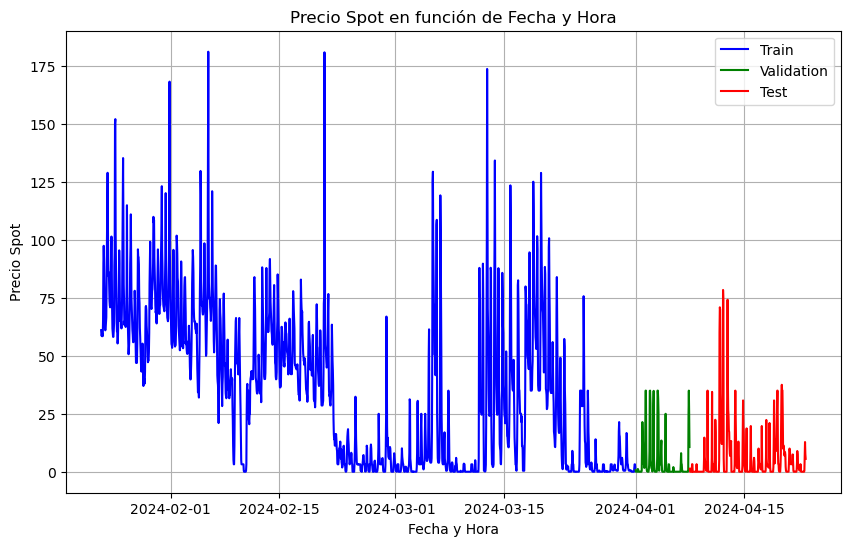

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['fechaHora'], train_data['precio_spot'], color='blue', label='Train')
plt.plot(val_data['fechaHora'], val_data['precio_spot'], color='green', label='Validation')

plt.plot(test_data['fechaHora'], test_data['precio_spot'], color='red', label='Test')

plt.xlabel('Fecha y Hora')
plt.ylabel('Precio Spot')
plt.title('Precio Spot en función de Fecha y Hora')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
train_data.drop(columns=['fechaHora'], inplace=True)
val_data.drop(columns=['fechaHora'], inplace=True)
test_data.drop(columns=['fechaHora'], inplace=True)


data = df_recent_data.copy()
# data = data.reset_index(drop=True)


C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\2604526388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=['fechaHora'], inplace=True)
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\2604526388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.drop(columns=['fechaHora'], inplace=True)
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\2604526388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

# DATA NORMALIATION

## TRAIN

In [95]:
# Preprocesamiento de datos
# scaler_precio_spot = MinMaxScaler()
scaler_precio_spot = StandardScaler()
train_data['precio_spot'] = scaler_precio_spot.fit_transform(train_data[['precio_spot']])

scaler_demanda = MinMaxScaler()
train_data['demanda'] = scaler_demanda.fit_transform(train_data[['demanda']])

scaler_co2 = MinMaxScaler()
train_data['co2'] = scaler_co2.fit_transform(train_data[['co2']])

scaler_precio_gas = MinMaxScaler()
train_data['precio_gas'] = scaler_precio_gas.fit_transform(train_data[['precio_gas']])

scaler_prod_eolica = MinMaxScaler()
train_data['prod_eolica'] = scaler_prod_eolica.fit_transform(train_data[['prod_eolica']])

scaler_prod_solar = MinMaxScaler()
train_data['prod_solar'] = scaler_prod_solar.fit_transform(train_data[['prod_solar']])

scaler_demanda_residual = MinMaxScaler()
train_data['demanda_residual'] = scaler_demanda_residual.fit_transform(train_data[['demanda_residual']])

scaler_rampa = MinMaxScaler()
train_data['rampa'] = scaler_rampa.fit_transform(train_data[['rampa']])



C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\667146575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['precio_spot'] = scaler_precio_spot.fit_transform(train_data[['precio_spot']])
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\667146575.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['demanda'] = scaler_demanda.fit_transform(train_data[['demanda']])
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\667146575.py:10: SettingWithCopyWarning: 
A value is trying to be set 

## VAL

In [96]:

val_data['precio_spot'] = scaler_precio_spot.transform(val_data[['precio_spot']])

val_data['demanda'] = scaler_demanda.transform(val_data[['demanda']])

val_data['co2'] = scaler_co2.transform(val_data[['co2']])

val_data['precio_gas'] = scaler_precio_gas.transform(val_data[['precio_gas']])

val_data['prod_eolica'] = scaler_prod_eolica.transform(val_data[['prod_eolica']])

val_data['prod_solar'] = scaler_prod_solar.transform(val_data[['prod_solar']])

val_data['demanda_residual'] = scaler_demanda_residual.transform(val_data[['demanda_residual']])

val_data['rampa'] = scaler_rampa.transform(val_data[['rampa']])

C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\2127852279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['precio_spot'] = scaler_precio_spot.transform(val_data[['precio_spot']])
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\2127852279.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['demanda'] = scaler_demanda.transform(val_data[['demanda']])
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\2127852279.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

## TEST

In [97]:

test_data['precio_spot'] = scaler_precio_spot.transform(test_data[['precio_spot']])

test_data['demanda'] = scaler_demanda.transform(test_data[['demanda']])

test_data['co2'] = scaler_co2.transform(test_data[['co2']])

test_data['precio_gas'] = scaler_precio_gas.transform(test_data[['precio_gas']])

test_data['prod_eolica'] = scaler_prod_eolica.transform(test_data[['prod_eolica']])

test_data['prod_solar'] = scaler_prod_solar.transform(test_data[['prod_solar']])

test_data['demanda_residual'] = scaler_demanda_residual.transform(test_data[['demanda_residual']])

test_data['rampa'] = scaler_rampa.transform(test_data[['rampa']])


C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\616695112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['precio_spot'] = scaler_precio_spot.transform(test_data[['precio_spot']])
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\616695112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['demanda'] = scaler_demanda.transform(test_data[['demanda']])
C:\Users\nicov\AppData\Local\Temp\ipykernel_31964\616695112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [98]:
train_data

,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
44351,0.770819,0.733108,0.785203,0.835796,0.391284,0.000335,0.576000,0.545909
44352,0.707116,0.687758,0.785203,0.835796,0.379745,0.000340,0.535158,0.589663
44353,0.691948,0.657042,0.785203,0.835796,0.363580,0.000349,0.516979,0.540165
44354,0.733507,0.643636,0.785203,0.835796,0.342216,0.000335,0.505366,0.525824
44355,0.691948,0.643850,0.785203,0.835796,0.323751,0.000368,0.507994,0.494721
...,...,...,...,...,...,...,...,...
46001,-1.082651,0.663200,0.721559,0.840722,0.543386,0.195930,0.365279,0.265628
46002,-1.031385,0.733499,0.721559,0.840722,0.623162,0.027047,0.456834,0.300500
46003,-0.985579,0.789406,0.721559,0.840722,0.690979,0.008862,0.496384,0.414082
46004,-0.985579,0.753214,0.721559,0.840722,0.676902,0.008560,0.411268,0.686359


# CREATE SEQUENCES

Existen multiples formas de crear secuencias dentro de nuestra serie temporal para el entrenamiento. La mas comun suele ser coger una secuencia de longitud 'n' para predecir el valor 'n+1', posteriormennte desplazamos la serie en 1 unidad y volvemos a crear una secuencia de longitud 'n' en la que su ultimo valor sera 'n+1' y se predecira 'n+2'.

Esta seria una implementacion correcta, pero no la mas adecuada para nuestro problema. Nosotros, en primer lugar, debemos predecir los proximos 24 valores, no uno unico. Ademas como hemos visto nuestra serie temporal tiene una distribucion concreta, con 2 tramos horarios con valores mas elevados (picos), y con la implementacion anterior esta componente temporal se perderia. Por todo ello nuestra implementacion es la siguiente:
- Tomamos los primeros 24 valores, comenzando a las 00:00 de un dia 't'. (x)
- Con estos valores se predeciran los 24 proximos. (y)
- El desplazamiento sera de 24, de esta forma la siguiente secuencia en vez de comenzar a la 01:00 de 't' comenzara a las 00:00 de 't+1'.

El hecho de tomar los primeros 24 valores es para predecir con los datos del dia anterior (empiricamente es lo que mejores resultados da), pero esto se puede modificar mediante el parametro 'seq_lenght' pudiendo predecir en base a los 2 ultimos dias (seq_length=48) por ejemplo.

In [99]:
X_train, y_train = create_sequences(train_data, seq_length, future_steps)
X_val, y_val = create_sequences(val_data, seq_length, future_steps)
X_test, y_test = create_sequences(test_data, seq_length, future_steps)

y_val = scaler_precio_spot.inverse_transform(y_val)
y_test = scaler_precio_spot.inverse_transform(y_test)



Vemos como se han creado 67 secuencias de entrenamiento de longitud 24 (1 dia) con sus 8 variables exogenas

In [100]:
X_train.shape

(67, 24, 8)

# MODELLING

Procedemos a comparar distintas arquitecturas de LSTM para evaluar cual se ajusta mejor a nuestra serie temporal.

## BASIC LSTM

En primer lugar vamos a modelar la red LSTM mas sencilla posible, con tan solo una capa con LSTM con 50 unidades y una capa densa de 24 neuronas (1 por cada hora del dia) que sera nuestro output.

In [101]:
model = Sequential()
model.add(LSTM(units=50,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=24))
model.compile(optimizer='adam', loss=custom_loss)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val)) 


Epoch 1/50
3/3 [==============================] - 2s 163ms/step - loss: 992.9923 - val_loss: 411239.3438
Epoch 2/50
3/3 [==============================] - 0s 24ms/step - loss: 960.5734 - val_loss: 410591.6562
Epoch 3/50
3/3 [==============================] - 0s 23ms/step - loss: 907.7637 - val_loss: 409778.8438
Epoch 4/50
3/3 [==============================] - 0s 23ms/step - loss: 868.5262 - val_loss: 408711.0312
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 778.8205 - val_loss: 407246.1562
Epoch 6/50
3/3 [==============================] - 0s 23ms/step - loss: 743.7134 - val_loss: 405132.1562
Epoch 7/50
3/3 [==============================] - 0s 24ms/step - loss: 647.7649 - val_loss: 402106.0000
Epoch 8/50
3/3 [==============================] - 0s 24ms/step - loss: 577.2010 - val_loss: 402658.7500
Epoch 9/50
3/3 [==============================] - 0s 26ms/step - loss: 565.2561 - val_loss: 403917.7500
Epoch 10/50
3/3 [==============================] - 0s 25ms/step

Procedemos a evaluar el modelo con el conjunto de validacion. No haremos plot de la grafica de entrenamiento puesto que la loss fijada al tener terminos exponenciales los errores en validacion se alejan mucho de los de entrenamiento, por lo que no es representativa.

Mean Squared Error (MSE): 91.52105665715813
Mean Absolute Error (MAE): 5.703018836316963
Valor de custom loss: 279882.2414812634


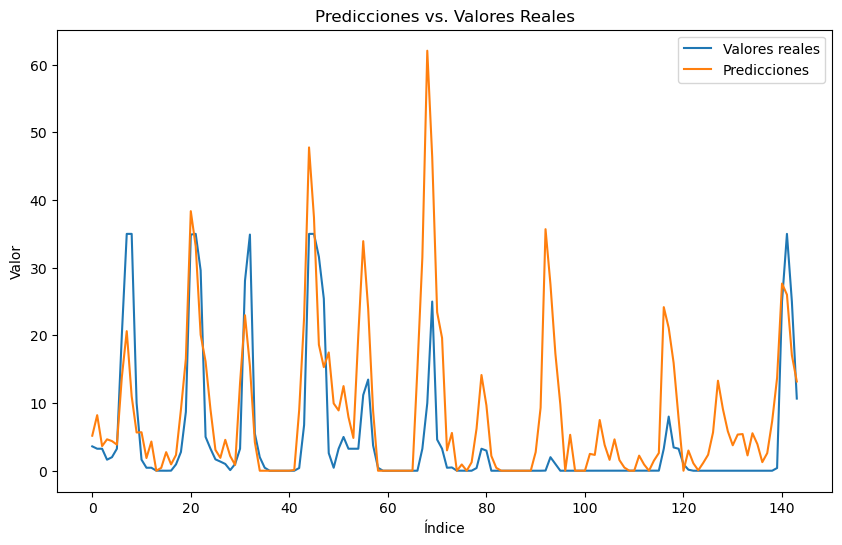

In [102]:

y_pred_basic = model.predict(X_val, verbose=0)

y_pred_basic = scaler_precio_spot.inverse_transform(y_pred_basic)
y_pred_basic = np.where(y_pred_basic < 0, 0, y_pred_basic)


mse = mean_squared_error(y_val, y_pred_basic)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_basic)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_basic)
print("Valor de custom loss:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_basic.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


Como podemos observar el modelo en su forma mas basica no se ajusta nada mal a la serie temporal. Procedemos a aumentar la complejidad del modelo.

## MULTILAYER LSTM

En esta aproximacion tendremos varias capas LSTM.

In [103]:
# Crear el modelo LSTM
lstm2 = Sequential()
lstm2.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm2.add(LSTM(50, activation='relu', return_sequences=True))
lstm2.add(LSTM(50, activation='relu'))
lstm2.add(Dense(24))
lstm2.compile(optimizer='adam', loss=custom_loss)

# Entrenar el modelo
history = lstm2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val)) #



Epoch 1/50
3/3 [==============================] - 5s 328ms/step - loss: 986.6532 - val_loss: 412855.4062
Epoch 2/50
3/3 [==============================] - 0s 46ms/step - loss: 983.0337 - val_loss: 412293.5938
Epoch 3/50
3/3 [==============================] - 0s 46ms/step - loss: 988.8758 - val_loss: 411638.4062
Epoch 4/50
3/3 [==============================] - 0s 46ms/step - loss: 924.5533 - val_loss: 410481.7500
Epoch 5/50
3/3 [==============================] - 0s 46ms/step - loss: 919.0797 - val_loss: 407641.3750
Epoch 6/50
3/3 [==============================] - 0s 46ms/step - loss: 868.8904 - val_loss: 400522.5000
Epoch 7/50
3/3 [==============================] - 0s 45ms/step - loss: 830.5685 - val_loss: 400911.3750
Epoch 8/50
3/3 [==============================] - 0s 46ms/step - loss: 732.0493 - val_loss: 402280.5938
Epoch 9/50
3/3 [==============================] - 0s 49ms/step - loss: 679.6395 - val_loss: 409063.9688
Epoch 10/50
3/3 [==============================] - 0s 45ms/step

Mean Squared Error (MSE): 82.49829944595116
Mean Absolute Error (MAE): 4.756600013851291
Valor de la métrica personalizada: 225243.31103465054


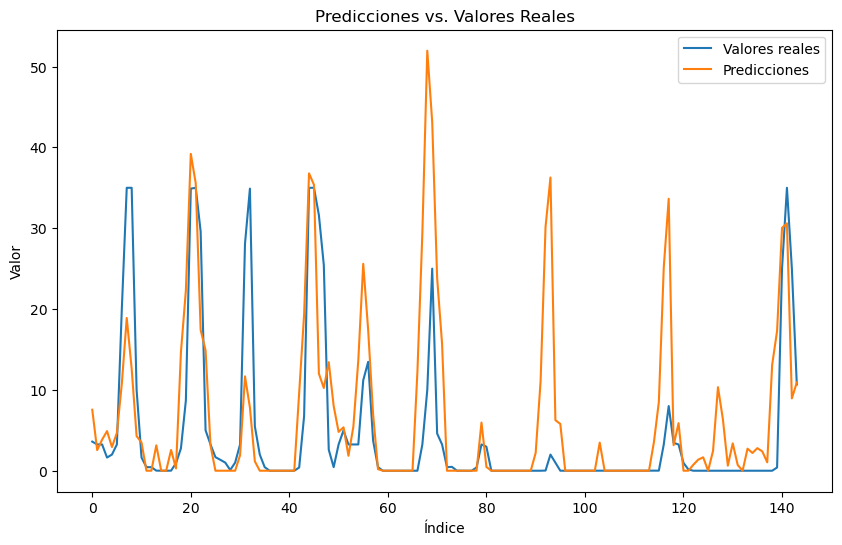

In [104]:
y_pred_multi = lstm2.predict(X_val, verbose=0)

y_pred_multi = scaler_precio_spot.inverse_transform(y_pred_multi)
y_pred_multi = np.where(y_pred_multi < 0, 0, y_pred_multi)

mse = mean_squared_error(y_val, y_pred_multi)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_multi)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_multi)
print("Valor de la métrica personalizada:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_multi.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

El modelo se ajusta ligeramente mejor a los datos. Probamos a incluir dropout y regularizacion L2 para tratar de mejorar las predicciones.

### DROPOUT

In [105]:
from keras.regularizers import l2

# Crear el modelo LSTM
lstm_drop = Sequential()
lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm_drop.add(LSTM(50, activation='relu', return_sequences=True,kernel_regularizer=l2(0.01)))
lstm_drop.add(Dropout(0.2))
lstm_drop.add(LSTM(50, activation='relu',kernel_regularizer=l2(0.01)))
lstm_drop.add(Dense(100))
lstm_drop.add(Dense(50))
lstm_drop.add(Dense(24))
lstm_drop.compile(optimizer='adam', loss=custom_loss)

# Entrenar el modelo
history = lstm_drop.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val)) #



Epoch 1/50
3/3 [==============================] - 6s 365ms/step - loss: 1002.9622 - val_loss: 410069.1250
Epoch 2/50
3/3 [==============================] - 0s 49ms/step - loss: 921.9005 - val_loss: 406176.4688
Epoch 3/50
3/3 [==============================] - 0s 49ms/step - loss: 822.7891 - val_loss: 399247.5000
Epoch 4/50
3/3 [==============================] - 0s 51ms/step - loss: 689.9901 - val_loss: 390979.7500
Epoch 5/50
3/3 [==============================] - 0s 52ms/step - loss: 703.2597 - val_loss: 397110.4062
Epoch 6/50
3/3 [==============================] - 0s 50ms/step - loss: 612.3035 - val_loss: 401850.0938
Epoch 7/50
3/3 [==============================] - 0s 48ms/step - loss: 596.9853 - val_loss: 404344.0938
Epoch 8/50
3/3 [==============================] - 0s 51ms/step - loss: 552.4162 - val_loss: 406019.0312
Epoch 9/50
3/3 [==============================] - 0s 49ms/step - loss: 533.9746 - val_loss: 408767.0938
Epoch 10/50
3/3 [==============================] - 0s 50ms/ste

Mean Squared Error (MSE): 71.12808942100102
Mean Absolute Error (MAE): 4.635571487498367
Valor de la métrica personalizada: 178724.11787641147


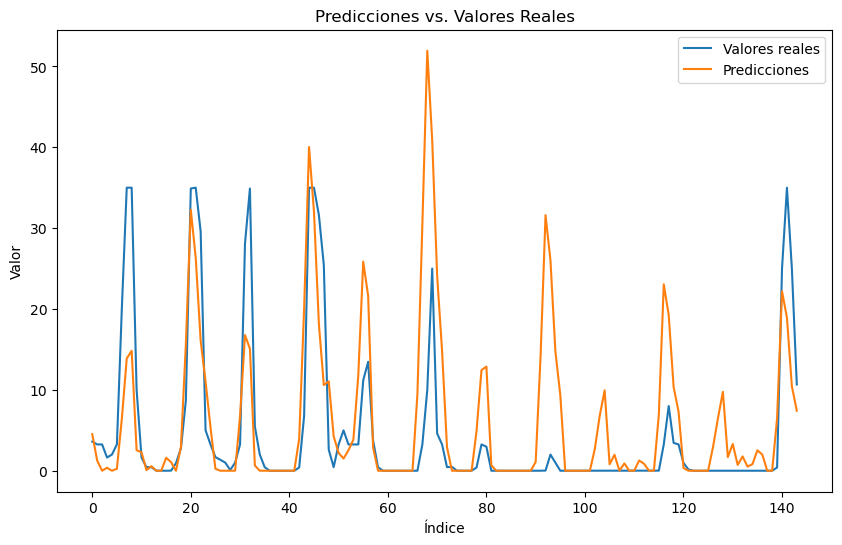

In [106]:
y_pred_drop = lstm_drop.predict(X_val, verbose=0)

y_pred_drop = scaler_precio_spot.inverse_transform(y_pred_drop)
y_pred_drop = np.where(y_pred_drop < 0, 0, y_pred_drop)

mse = mean_squared_error(y_val, y_pred_drop)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_val, y_pred_drop)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_val, y_pred_drop)
print("Valor de la métrica personalizada:", metric_value.numpy())

# Plot de las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Valores reales')
plt.plot(y_pred_drop.flatten(), label='Predicciones')
# plt.plot(np.array(df_last2['precio_spot']), label='ts')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

El modelo mejora ligeramente respecto al anterior sin capas de dropout y regularizacion. Las metricas son muy similares. 

## GRID SEARCH

Implementacion de busqueda de parametros. Los "mejores" modelos que devuelve siempre son notablemente peores que los obtenidos manualmente.

In [107]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def build_model(hp):
    model = Sequential()
    
    # Capas LSTM
    for i in range(hp.Int('num_lstm_layers', 1, 3)):  # Agregar de 1 a 3 capas LSTM
        return_sequences = True if i < hp.Int('num_lstm_layers', 1, 3) - 1 else False
        model.add(LSTM(units=hp.Int('units_lstm_' + str(i), min_value=10, max_value=128, step=10),
                       return_sequences=return_sequences,
                       dropout=hp.Float('dropout_lstm_' + str(i), min_value=0.0, max_value=0.5, step=0.1),
                       recurrent_dropout=hp.Float('recurrent_dropout_lstm_' + str(i), min_value=0.0, max_value=0.5, step=0.1),
                       input_shape=(X_train.shape[1], X_train.shape[2])))
    
    # Capas densas
    for i in range(hp.Int('num_dense_layers', 1, 3)):  # Agregar de 1 a 3 capas densas
        model.add(Dense(units=hp.Int('units_dense_' + str(i), min_value=24, max_value=200, step=25),
                        activation=hp.Choice('activation_dense_' + str(i), ['relu', 'tanh', 'sigmoid']),
                        kernel_regularizer=regularizers.l2(hp.Float('l2_regularizer_' + str(i), min_value=0.0, max_value=0.1, step=0.01))))
        model.add(Dropout(hp.Float('dropout_dense_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(24))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'nadam', 'adamax', 'ftrl']),
                  loss=custom_loss)
    return model


In [108]:
# # Inicializar el sintonizador
# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='hyperparams',
#     project_name='lstm')

# # Realizar la búsqueda de hiperparámetros
# tuner.search(X_train, y_train,
#              epochs=50,
#              validation_data=(X_val, y_val))



In [109]:
# # Imprimir los mejores hiperparámetros encontrados
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("Mejor conjunto de hiperparámetros encontrado:")
# print(best_hps.values)

In [110]:

# best_model = tuner.get_best_models(num_models=1)[0]

# y_pred_cnn_lstm = best_model.predict(X_val, verbose=0)

# y_pred_cnn_lstm = scaler_precio_spot.inverse_transform(y_pred_cnn_lstm)
# y_pred_cnn_lstm = np.where(y_pred_cnn_lstm < 0, 0, y_pred_cnn_lstm)


# mse = mean_squared_error(y_val, y_pred_cnn_lstm)
# print('Mean Squared Error (MSE):', mse)

# # Calcular el Error Absoluto Medio (MAE)
# mae = mean_absolute_error(y_val, y_pred_cnn_lstm)
# print('Mean Absolute Error (MAE):', mae)

# metric_value = custom_loss(y_val, y_pred_cnn_lstm)
# print("Valor de la métrica personalizada:", metric_value.numpy())

# # Plot de las predicciones vs. los valores reales
# plt.figure(figsize=(10, 6))
# plt.plot(y_val.flatten(), label='Valores reales')
# plt.plot(y_pred_cnn_lstm.flatten(), label='Predicciones')
# # plt.plot(np.array(df_last2['precio_spot']), label='ts')
# plt.title('Predicciones vs. Valores Reales')
# plt.xlabel('Índice')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()


Curiosamente mediante una busqueda de hiperparametros no hallamos un buen modelo, este sera totalmente descartado.

# MODELS COMPARATIVE

Procedemos a visualizar las predicciones de los 3 modelos:

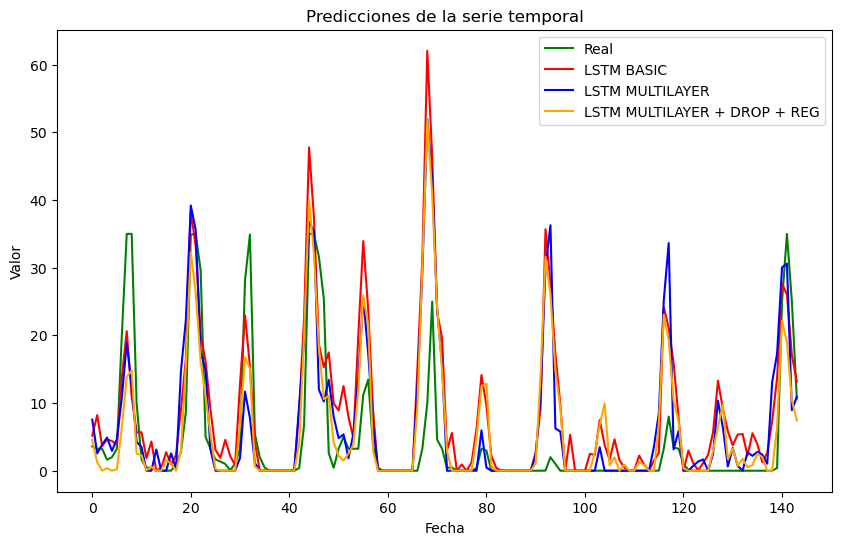

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(y_val.flatten(), label='Real', color='green')
plt.plot(y_pred_basic.flatten(), label='LSTM BASIC', color='red')
plt.plot(y_pred_multi.flatten(), label='LSTM MULTILAYER', color='blue')
plt.plot(y_pred_drop.flatten(), label='LSTM MULTILAYER + DROP + REG', color='orange')


plt.title('Predicciones de la serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Esta grafica nos simplifica la tarea de decidir un mejor modelo. El modelo basico tiende a sobreestimar los valores y es el que peores metricas obtiene, por tanto sera el primero en descartarse. Entre los 2 modelos restantes no hay mucha diferencia, debido a que tiene un MSE menor optamos por seleccionar como modelo ganador el LSTM multicapa con dropout  y regularizacion.

# TEST

Una vez hemos elegido nuestro modelo LSTM ganador procedemos a evaluarlo con el conjunto de test

1/1 [==============================] - 0s 30ms/step
Mean Squared Error (MSE): 97.55595138426338
Mean Absolute Error (MAE): 5.023542446891468
Valor de custom loss: 655337.4850459187


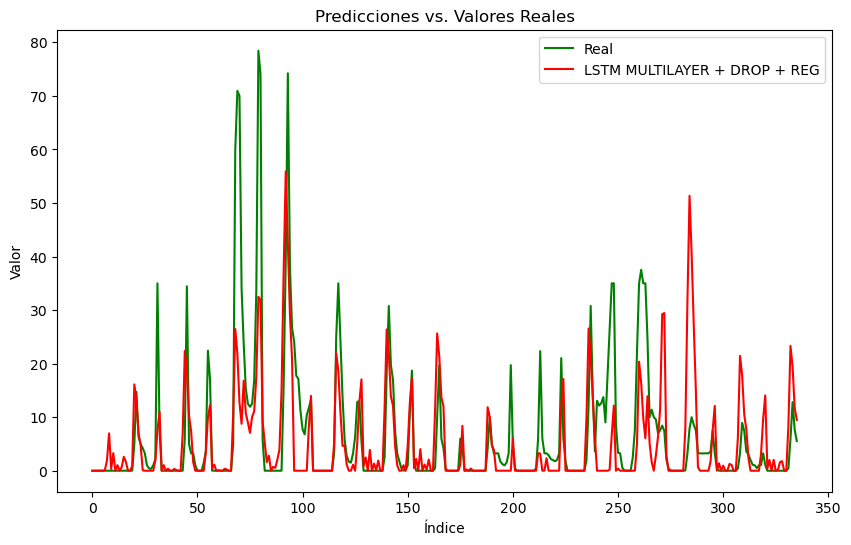

In [118]:

# Hacer predicciones
y_pred_test = lstm_drop.predict(X_test)

y_pred_test = scaler_precio_spot.inverse_transform(y_pred_test)
y_pred_test = np.where(y_pred_test < 0, 0, y_pred_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error (MSE):', mse)

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error (MAE):', mae)

metric_value = custom_loss(y_test, y_pred_test)
print("Valor de custom loss:", metric_value.numpy())


plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Real', color='green')
plt.plot(y_pred_test.flatten(), label='LSTM MULTILAYER + DROP + REG', color='red')
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

Como podemos observar obtenemos unas predicciones bastante prometedoras. En los 15 dias de test el modelo de media se equivoca en tan solo 5,023€ (MAE), lo cual es bastante positivo. 